In [ ]:
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
!pip install openpyxl xlrd
import seaborn as sns
import pandas as pd
import numpy as np 

# Loading the dataset

In [ ]:
try:
    df = pd.read_excel(r"E:\programming_projects\Fintech_payments_risk_analysis\data\raw\default_of_credit_card_clients.xls", header=1)
    print("Full dataset loaded")
except FileNotFoundError:
    df = pd.read_csv("data/samples/default_sample.csv")
    print("Sample dataset loaded")



# Double check: let's drop the first column if it's just a row counter
# Sometimes CSV exports add an unnamed 'Unnamed: 0' column at the start
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)


# English comment: Verify that column names are now correct (LIMIT_BAL, SEX, etc.)
print("Columns after cleaning:", df.columns.tolist())    

Full dataset loaded
Columns after cleaning: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


# Data Preparation

In [51]:
# 2. Drop the 'ID' column
df.drop('ID', axis=1, inplace=True)

# 3. Clean 'EDUCATION' column
# Documented values: 1 = graduate school, 2 = university, 3 = high school, 4 = others.
# We map undocumented values (0, 5, 6) to category 4 (others).
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

# 4. Clean 'MARRIAGE' column
# Documented values: 1 = married, 2 = single, 3 = others.
# We map the undocumented value 0 to 3 (others).
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

# 5. Rename target column for convenience
# Renaming 'default payment next month' to 'default' makes it easier to reference.
df.rename(columns={'default payment next month': 'default'}, inplace=True)

# 6. Basic Data Sanity Check
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Variable Distribution:\n", df['default'].value_counts(normalize=True))

# Display the first few rows
df.head()

Dataset Shape: (30000, 24)

Missing Values:
 LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

Target Variable Distribution:
 default
0    0.7788
1    0.2212
Name: proportion, dtype: float64


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory Data Analysis (EDA)

C:\Users\Maxone\AppData\Local\Temp\ipykernel_10432\3840641860.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default', data=df, palette='viridis')


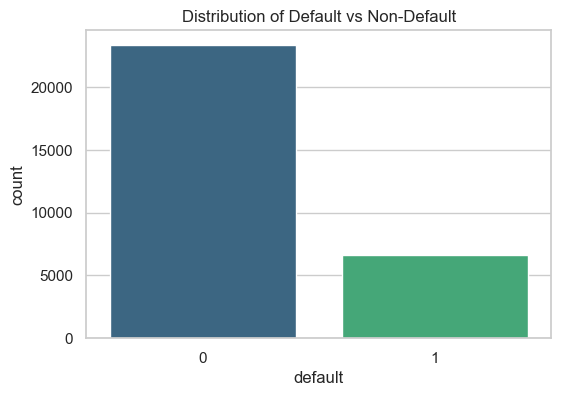

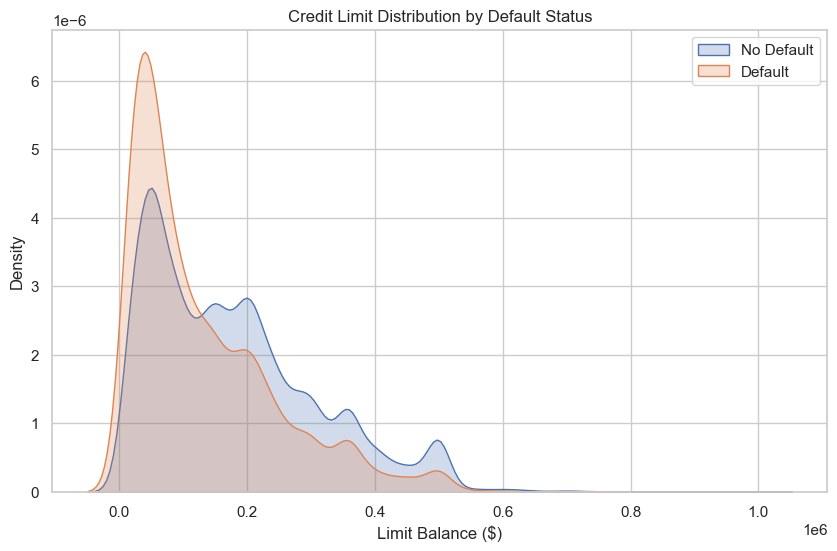

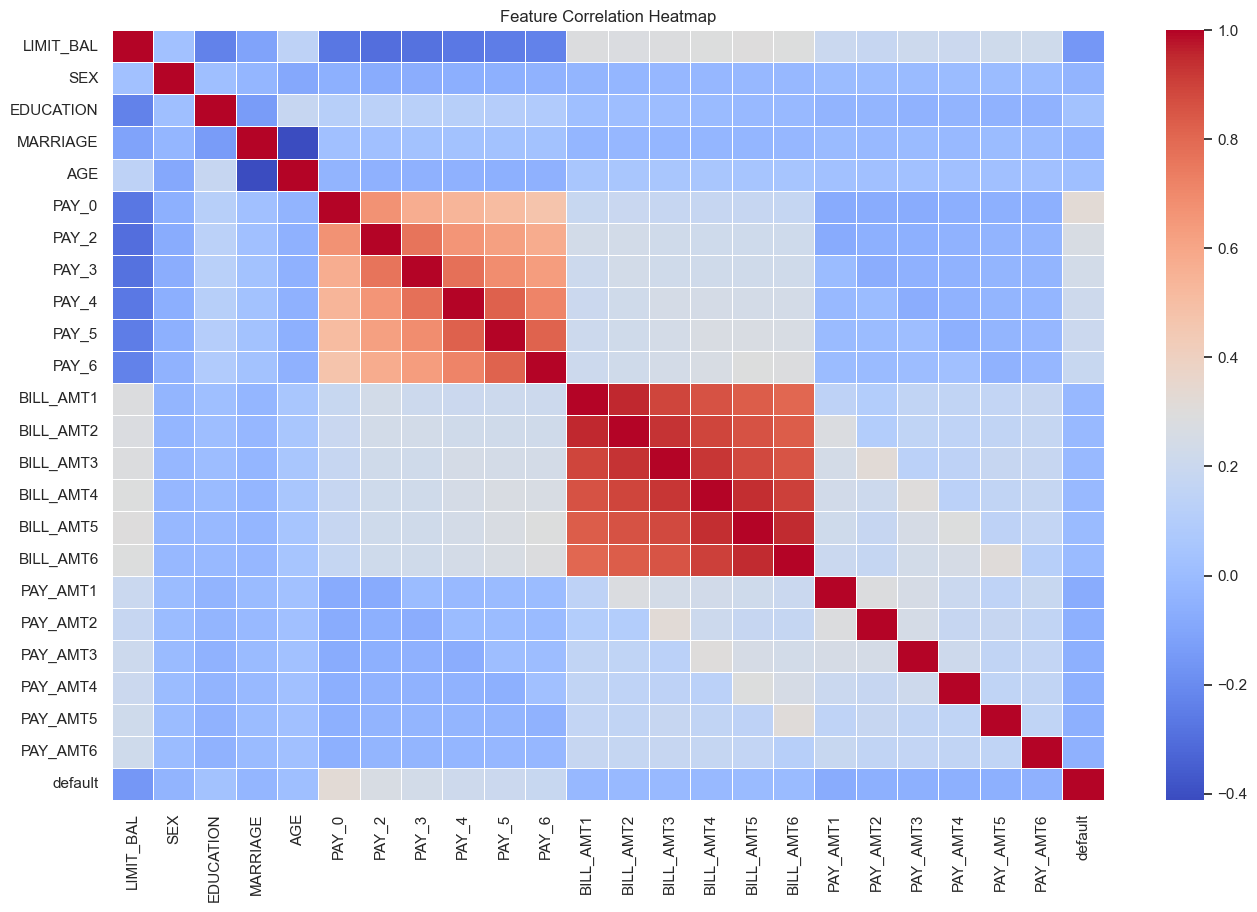

In [52]:
# Set visual style
sns.set_theme(style="whitegrid")

# 1. Target Variable Distribution visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=df, palette='viridis')
plt.title('Distribution of Default vs Non-Default')
plt.show()

# 2. Credit Limit Distribution by Default Status
plt.figure(figsize=(10, 6))
sns.kdeplot(df.loc[(df['default'] == 0), 'LIMIT_BAL'], label='No Default', fill=True)
sns.kdeplot(df.loc[(df['default'] == 1), 'LIMIT_BAL'], label='Default', fill=True)
plt.title('Credit Limit Distribution by Default Status')
plt.xlabel('Limit Balance ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(16, 10))
# Calculate correlation matrix
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Engineering

In [53]:
# 1. Create features (as before)
df['UTILIZATION_SEP'] = df['BILL_AMT1'] / df['LIMIT_BAL']
df['UTILIZATION_AUG'] = df['BILL_AMT2'] / df['LIMIT_BAL']
df['PAY_RATIO_SEP'] = df['PAY_AMT1'] / (df['BILL_AMT2'] + 1)
df['BILL_CHG'] = df['BILL_AMT1'] - df['BILL_AMT2']

# --- FIX START ---
# 2. Replace infinite values with 0
# (Infinite usually happens when dividing by zero)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Fill NaN values with 0
# (NaNs happen if we have 0/0 or after replacing inf)
df.fillna(0, inplace=True)
# --- FIX END ---

print("Infinite and NaN values handled.")

Infinite and NaN values handled.


# One-Hot Encoding

In [54]:
# Convert categorical variables to string names for clearer encoding
df['SEX'] = df['SEX'].map({1: 'male', 2: 'female'})
df['MARRIAGE'] = df['MARRIAGE'].map({1: 'married', 2: 'single', 3: 'others'})

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=['SEX', 'MARRIAGE'], prefix=['SEX', 'MAR'])

# Note: For EDUCATION we can keep it as is or also encode. 
# Let's keep it simple for now as it has a semi-ordinal nature.

# Scaling & Train-Test Split

In [55]:
# 1. Define features (X) and target (y)
X = df.drop('default', axis=1)
y = df['default']

# 2. Split the data into training and testing sets
# We set test_size=0.2 to keep 20% of data for the final evaluation
# Use stratify=y to maintain the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize the StandardScaler
scaler = StandardScaler()

# 4. Fit the scaler ONLY on the training data
# This computes the mean and standard deviation for scaling without "seeing" the test set
scaler.fit(X_train)

# 5. Transform both training and testing sets
# We apply the same scaling parameters (from X_train) to both sets to avoid data leakage
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled without data leakage.")

Data successfully split and scaled without data leakage.


In [35]:
# Create a DataFrame from the scaled data to see the column names
# We use X.columns because it contains the names after One-Hot Encoding
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

# Look at the first 5 rows
X_train_scaled_df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT6,UTILIZATION_SEP,UTILIZATION_AUG,PAY_RATIO_SEP,BILL_CHG,SEX_female,SEX_male,MAR_married,MAR_others,MAR_single
0,-0.056866,0.211520,-0.264558,1.793311,1.780193,2.652046,1.911811,0.240260,0.256087,1.505547,...,0.048745,1.431948,1.655996,-0.023610,-0.573241,0.80844,-0.80844,-0.911561,-0.112888,0.934945
1,-0.134081,-1.131465,-0.155804,0.902944,-0.722324,-0.697642,-1.530826,-1.537252,-1.489963,-0.695165,...,-0.292992,-1.031437,-1.015557,-0.019961,-0.094789,0.80844,-0.80844,-0.911561,-0.112888,0.934945
2,-1.215090,0.211520,1.584260,0.902944,1.780193,0.139780,0.190493,0.240260,0.256087,-0.556800,...,-0.236970,1.446643,1.002224,-0.023964,-0.002976,-1.23695,1.23695,1.097020,-0.112888,-1.069582
3,0.406423,-1.131465,-0.699574,0.012576,0.111849,0.139780,0.190493,0.240260,0.256087,2.119190,...,0.043143,1.259670,1.359536,-0.023789,-0.276510,0.80844,-0.80844,-0.911561,-0.112888,0.934945
4,1.101358,-1.131465,-0.373312,0.902944,-1.556496,-0.697642,0.190493,0.240260,-1.489963,-0.695165,...,-0.225765,-1.031437,-1.016432,-0.023965,-0.092443,0.80844,-0.80844,-0.911561,-0.112888,0.934945


# Random Forest

In [39]:
# 1. Initialize the model
# We use class_weight='balanced' to handle the 22% default rate
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,        # Ограничим глубину, чтобы избежать переобучения
    class_weight={0: 1, 1: 4}, # Вес для дефолта в 4 раза выше
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# 2. Train the model using the scaled training data
rf_model.fit(X_train_scaled, y_train)

# 3. Make predictions on the scaled test data
y_pred = rf_model.predict(X_test_scaled)

# 4. Print overall accuracy
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 5. Detailed report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 0.7722

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4673
           1       0.49      0.58      0.53      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.77      0.78      6000



--- FINAL MODEL PERFORMANCE (Threshold: 0.52) ---
Accuracy: 0.7845

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4673
           1       0.51      0.57      0.54      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.71      0.70      6000
weighted avg       0.79      0.78      0.79      6000



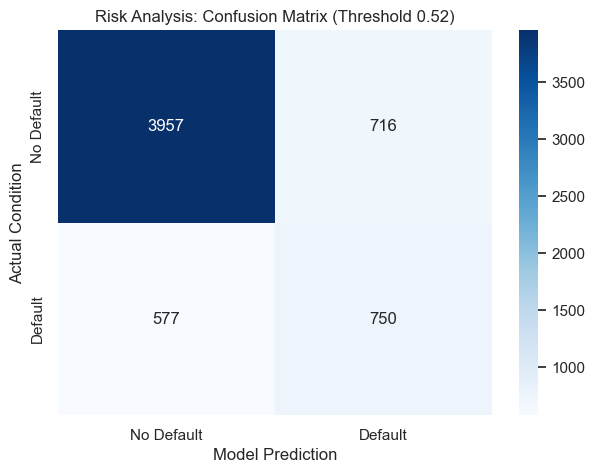

Model Insight: We successfully identified 750 out of 1327 potential defaults.


In [44]:
# 1. Get probabilities for the 'Default' class (1)
y_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# 2. Optimized Threshold Selection
# Threshold 0.52-0.55 works best when class_weight is already balanced
threshold = 0.52 
y_pred_final = (y_probs >= threshold).astype(int)

# 3. Comprehensive Report
print(f"--- FINAL MODEL PERFORMANCE (Threshold: {threshold}) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# 4. Confusion Matrix with professional styling
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'], 
            yticklabels=['No Default', 'Default'])

plt.title(f'Risk Analysis: Confusion Matrix (Threshold {threshold})')
plt.ylabel('Actual Condition')
plt.xlabel('Model Prediction')
plt.show()

# 5. Brief Analysis
# Calculating how many defaults we caught vs missed
total_defaults = cm[1].sum()
caught_defaults = cm[1, 1]
print(f"Model Insight: We successfully identified {caught_defaults} out of {total_defaults} potential defaults.")

C:\Users\Maxone\AppData\Local\Temp\ipykernel_10432\3670093919.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances.head(15), palette='coolwarm')


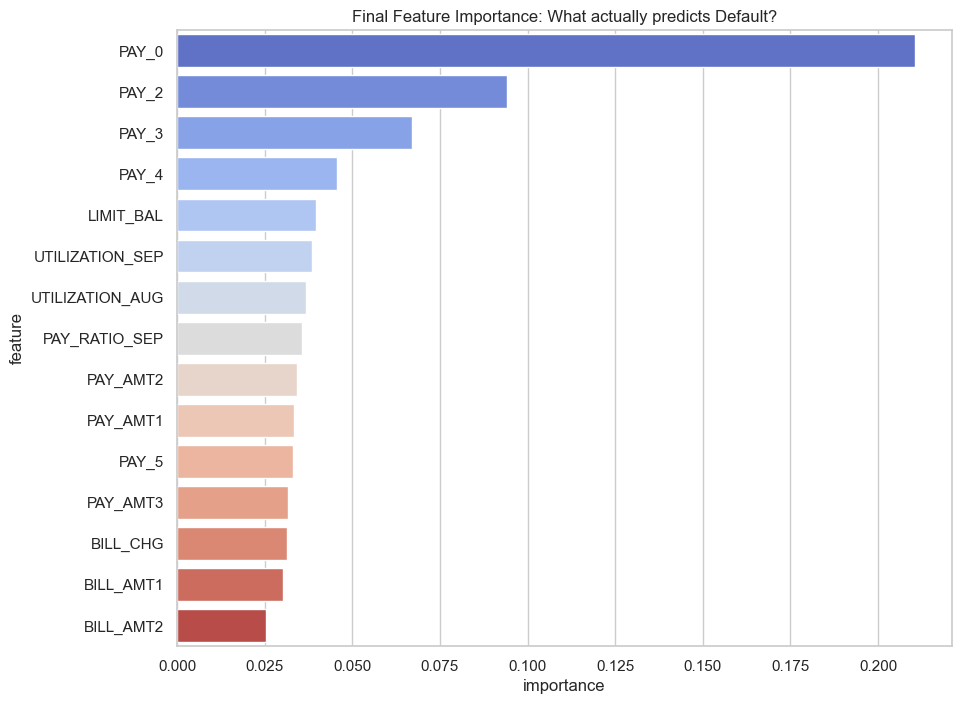

In [45]:
# Create importance dataframe
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizing the TOP features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importances.head(15), palette='coolwarm')
plt.title('Final Feature Importance: What actually predicts Default?')
plt.show()

**Random Forest (Threshold 0.52, Weighted Classes)** — Accuracy 78.5%, Recall 57%, Precision 51%.  
**Key Drivers:** Payment history (PAY_0) & custom Utilization ratios.  
**Outcome:** Balanced risk detection and business stability, catching most defaults while minimizing false alarms.

# XGBoost

In [ ]:
# 1. Compute class imbalance weight (ratio of negative to positive cases)
# In our case it is approximately 3.5 (for 1 default there are ~3.5 non-default clients)
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

# 2. Initialize the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,             # Boosting trees are usually shallow
    learning_rate=0.1,       # Learning rate
    scale_pos_weight=ratio,  # Class imbalance handling
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Train the model
xgb_model.fit(X_train_scaled, y_train)

# 4. Make predictions using the same threshold for fair comparison
y_probs_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.52
y_pred_xgb = (y_probs_xgb >= threshold).astype(int)

# 5. Evaluation
print("--- XGBoost Performance ---")
print(classification_report(y_test, y_pred_xgb))

--- XGBoost Performance ---
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4673
           1       0.48      0.61      0.54      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.77      0.78      6000



c:\Maxone\Programms\miniconda\envs\myenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
